# Local plasticity solver

$\newcommand{\beps}{\boldsymbol{\varepsilon}}
\newcommand{\bepsp}{\boldsymbol{\varepsilon}^\text{p}}
\newcommand{\Deps}{\Delta\boldsymbol{\varepsilon}}
\newcommand{\Depsp}{\Delta\boldsymbol{\varepsilon}^\text{p}}
\newcommand{\bepsel}{\boldsymbol{\varepsilon}^\text{el}}
\newcommand{\bsig}{\boldsymbol{\sigma}}
\newcommand{\bsigtr}{\boldsymbol{\sigma}^\text{tr}}
\newcommand{\bu}{\boldsymbol{u}}
\newcommand{\CC}{\mathbb{C}}
\newcommand{\KK}{\mathbb{K}}
\newcommand{\JJ}{\mathbb{J}}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\Kk}{\mathcal{K}}
\newcommand{\tr}{\operatorname{tr}}
\newcommand{\dev}{\operatorname{dev}}
\newcommand{\bf}{\boldsymbol{f}}
\newcommand{\dOm}{\text{d}\Omega}
\DeclareMathOperator*{argmin}{arg\min}
\newcommand{\bC}{\boldsymbol{C}}
\newcommand{\bQ}{\boldsymbol{Q}}
\newcommand{\bx}{\boldsymbol{x}}
\newcommand{\T}{^\text{T}}$

In elastoplastic problems, the standard numerical strategy to solve the corresponding nonlinear equations is to resort to a Newton-Raphson method at the global structural scale and a local nonlinear solver at the material point level to solve the plasticity evolution equations. In such a setting, the latter problem is driven by a given strain increment and a predictor/corrector strategy is generally used. One indeed assumes a first elastic trial stress state. In the case the plasticity yield condition is violated, one must project the trial elastic field onto the yield surface. Various strategies for computing this projection are available in the litterature and most of them rely on a local Newton method as well. This approach may suffer from robustness issues if the elastic trial state is too large or in case of non-smooth yield surfaces (non-smooth yield criteria, multisurface plasticity, etc.).

In this demo, we formulate the plasticity projection step as a minimization problem to be solved with `fenics_optim`.

## Trial stress state projection

Let us consider a linear elastic setting characterized by some elastic stiffness tensor $\CC$. Consider also a previous stress state $\bsig_n$ and a given strain increment $\Deps$. The *trial* stress state is obtained assuming an elastic behaviour for the strain increment:
\begin{equation}
\bsigtr = \bsig_n + \CC:\Deps
\end{equation}

The *real* stress field is obtained by projecting this trial stress state onto the yield surface with respect to the distance induced by the elastic compliance stiffness tensor $\CC^{-1}$. That is, one wants to solve:
\begin{equation}
\begin{array}{rl}
\displaystyle{\bsig_{n+1} = \argmin_{\bsig}} & \displaystyle{\dfrac{1}{2}(\bsig-\bsigtr):\CC^{-1}:(\bsig-\bsigtr)} \\
\text{s.t.} & \bsig \in G
\end{array}
\end{equation}

In [138]:
from dolfin import UnitIntervalMesh, VectorFunctionSpace, Constant, dx
from fenics_optim import (
    MosekProblem,
    ConvexFunction,
    QuadraticTerm,
    Quad,
    Exp,
    tail,
    concatenate,
    to_vect,
    to_mat,
    SumExpr
)
import fenics_optim.limit_analysis as la
from ufl import diag, as_vector, cos, sin, shape, sqrt
import numpy as np

mesh = UnitIntervalMesh(1)
theta = Constant(0)
sig0 = Constant(1.)
sigtr = sig0*as_vector([cos(theta), sin(theta), 0, 0, 0, 0])

metric = {3: diag(as_vector([1, 1, sqrt(2)])),
          6: diag(as_vector([1, 1, 1, sqrt(2),sqrt(2),sqrt(2)]))}
def project_stress(mat, rad, sigtr, plane_stress=True):
    dim = len(sigtr)
    V = VectorFunctionSpace(mesh, "R", 0, dim=dim)
    prob = MosekProblem("Local plasticity solver")
    sig = prob.add_var(V)
    
    Q = metric[dim]
    dist = QuadraticTerm(sig, Q=Q, x0=Constant(rad)*sigtr)
    
    crit = mat.criterion(sig)
    
    
    prob.add_convex_term(crit)
    prob.add_convex_term(dist)
    if dim == 6 and plane_stress:
        prob.add_eq_constraint(V.sub(0).collapse(), A=lambda x: x*sig[2]*dx)
    
    prob.parameters["log_level"] = 0
    prob.optimize()
    it = prob.get_solution_info(False)["intpnt_iter"]

    return sig.vector()[:], it

def plot_results(Sig, iterations):
    vmin = min([min(it) for it in iterations.values()])
    vmax = max([max(it) for it in iterations.values()])
    c = np.linspace(0, 1, 50)
    colors = plt.cm.plasma(c)
    cmap = mpl.colors.ListedColormap(colors)
    ax = plt.gca()
    dummie_ax = ax.scatter(c, c, c=vmin+(vmax-vmin)*c, cmap=cmap)
    ax.cla()
    cbar = plt.colorbar(dummie_ax, cmap=cmap)
    #plt.clim(vmin, vmax)
    cbar.set_label("Number of iterations")

    def to_col(v):
        loc = int((v-vmin)/(vmax-vmin)*(len(c)-1))
        return colors[loc, :]
    for r, Sig_r in Sig.items():
        for (sig, it) in zip(Sig_r, iterations[r]):
            Sig_r = np.asarray(Sig_r)
            col = to_col(it)
            plt.plot(sig[0], sig[1], "o", color=col)
        new_Sig = np.vstack((Sig_r, Sig_r[[0], :]))
        plt.plot(new_Sig[:, 0], new_Sig[:, 1], "-k", linewidth=0.5)
    plt.gca().set_aspect("equal")
    plt.show()

In [130]:
mat = la.MohrCoulomb3D(1, np.pi/6)

Sig = {}
iterations = {}
for rad in [5, 10, 20, 30]:
    Sig[rad] = []
    iterations[rad] = []
    for t in np.linspace(-np.pi, np.pi, 41):
        theta.assign(Constant(t))
        sig, it = project_stress(mat, rad, sigtr)
        Sig[rad].append(float(rad)*sig)
        iterations[rad].append(it)

/home/bleyerj/Fenics/fenics-optim/fenics_optim/limit_analysis/materials/strength_criterion.py:99: UserWarning: 
-----------
MohrCoulomb3D disc_support_function not implemented!
-----------
  warnings.warn(


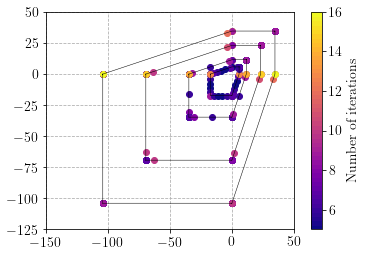

In [139]:
plot_results(Sig, iterations)